<a href="https://colab.research.google.com/github/trannguyen1510/My-stuff/blob/master/Occupancy_Dectection_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np 
import matplotlib.pyplot as plt

# Mục mới

In [ ]:
# Tab này chỉ host chạy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Tab này chỉ host chạy
path_dir = '/content/drive/My Drive/ĐH/Data Mining/Dataset'
path_data = path_dir + '/New.txt'

dataset = pd.read_csv(path_data)
train_data = pd.read_csv(path_dir + '/datatraining.txt')
val_data = pd.read_csv(path_dir + '/datatest.txt')
test_data = pd.read_csv(path_dir + '/datatest2.txt')

In [ ]:
feature_cols = ["date", "Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]
lable_cols = ["Occupancy"]

In [ ]:
print(dataset.shape)

(20560, 7)


In [ ]:
feature_cols = ["date", "Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]
lable_cols = ["Occupancy"]

In [ ]:
# TRAIN
print("***** Training DATA *****")
X_train_raw = train_data[feature_cols]
print(X_train_raw.shape)

Y_train_raw = train_data[lable_cols]
print(Y_train_raw.shape)

# VAL
print("***** Validation DATA *****")

X_val_raw = val_data[feature_cols]
print(X_val_raw.shape)

Y_val_raw = val_data[lable_cols]
print(Y_val_raw.shape)

# TEST
print("***** TEST DATA *****")

X_test_raw = test_data[feature_cols]
print(X_test_raw.shape)

Y_test_raw = test_data[lable_cols]
print(Y_test_raw.shape)

***** Training DATA *****
(8143, 6)
(8143, 1)
***** Validation DATA *****
(2665, 6)
(2665, 1)
***** TEST DATA *****
(9752, 6)
(9752, 1)


In [ ]:
print(train_data.head(10))

                   date  Temperature  ...  HumidityRatio  Occupancy
1   2015-02-04 17:51:00       23.180  ...       0.004793          1
2   2015-02-04 17:51:59       23.150  ...       0.004783          1
3   2015-02-04 17:53:00       23.150  ...       0.004779          1
4   2015-02-04 17:54:00       23.150  ...       0.004772          1
5   2015-02-04 17:55:00       23.100  ...       0.004757          1
6   2015-02-04 17:55:59       23.100  ...       0.004757          1
7   2015-02-04 17:57:00       23.100  ...       0.004757          1
8   2015-02-04 17:57:59       23.100  ...       0.004757          1
9   2015-02-04 17:58:59       23.100  ...       0.004757          1
10  2015-02-04 18:00:00       23.075  ...       0.004745          1

[10 rows x 7 columns]


In [ ]:
from datetime import datetime

def create_new_features(data):
    time_buckets = []
    weekday = []

    for index, row in data.iterrows():
        parsed_date = datetime.strptime(row['date'], "%Y-%m-%d %H:%M:%S")
        time_bucket = parsed_date.hour % 4 # lets divide in to [day 6-12, afternoon 12-6, evening 6-12, night 12-6]
        time_buckets.append(time_bucket)
        wday = 0 if parsed_date.isoweekday() > 5 else 1
        weekday.append(wday)
    return time_buckets, weekday

train_time_buckets, train_weekday = create_new_features(train_data)
val_time_buckets, val_weekday = create_new_features(val_data)
test_time_buckets, test_weekday = create_new_features(test_data)

In [ ]:
li = [train_weekday, val_weekday, test_weekday]
for i in li:
  count = 0
  for j in i:
    if j == 0:
      count += 1
  print('Train_val:')
  print('--0:', count)
  print('--1:', len(i) - count)

Train_val:
--0: 2880
--1: 5263
Train_val:
--0: 0
--1: 2665
Train_val:
--0: 2880
--1: 6872


In [ ]:
#Validation dataset did not have any values with occupancy 0. So we are adding one here
val_weekday[-1] = 0

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def onehot_encode(values):
    new_values = np.array(values)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(new_values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return (onehot_encoded, label_encoder.classes_)

# TRAINING DATA
train_time_bucket_onehot_encoded, train_time_class = onehot_encode(train_time_buckets)
train_weekday_onehot_encoded, train_weekday_class = onehot_encode(train_weekday)
print(train_time_bucket_onehot_encoded, train_time_class)
print(train_weekday_onehot_encoded, train_weekday_class)


# VALIDATION DATA
val_time_bucket_onehot_encoded, val_time_class = onehot_encode(val_time_buckets)
val_weekday_onehot_encoded, val_weekday_class = onehot_encode(val_weekday)
print(val_time_bucket_onehot_encoded, val_time_class)
print(val_weekday_onehot_encoded, val_weekday_class)


# TEST DATA
test_time_bucket_onehot_encoded, test_time_class = onehot_encode(test_time_buckets)
test_weekday_onehot_encoded, test_weekday_class = onehot_encode(test_weekday)
print(test_time_bucket_onehot_encoded, test_time_class)
print(test_weekday_onehot_encoded, test_weekday_class)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]] [0 1 2 3]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] [0 1]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]] [0 1 2 3]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]] [0 1]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]] [0 1 2 3]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] [0 1]


In [ ]:
# Append new features to Train, Validation and Test sets

def add_new_features(arr, week_onehot, time_onehot):
    # lets ignore the date column for all the rows
    X = arr.values[:, 1:] 
    XW = np.hstack((X, week_onehot))
    XTW = np.hstack((XW, time_onehot))
    return XTW

X_train = add_new_features(X_train_raw, train_weekday_onehot_encoded, train_time_bucket_onehot_encoded)
print(X_train.shape)

X_val = add_new_features(X_val_raw, val_weekday_onehot_encoded, val_time_bucket_onehot_encoded)
print(X_val.shape)

X_test = add_new_features(X_test_raw, test_weekday_onehot_encoded, test_time_bucket_onehot_encoded)
print(X_test.shape)

(8143, 11)
(2665, 11)
(9752, 11)


In [ ]:
Y_train = np.array(Y_train_raw)
Y_val = np.array(Y_val_raw)
Y_test = np.array(Y_test_raw)

type(Y_train[0][0])

numpy.int64

In [ ]:
Confusion Matrix:
- True Positives (TP)
- True Negatives (TN)
- False Positives (FP)
- False Negatives (FN)

Accuracy = TP+TN/TP+FP+FN+TN

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations
Precision = TP/(TP+FP)

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes
Recall = TP/(TP+FN)

F1 score - F1 Score is the weighted average of Precision and Recall
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

# **Decision Tree Classifier**

In [ ]:
model_dct = DecisionTreeClassifier().fit(X_train, Y_train.ravel())  # ccp_alpha tăng thì số nhánh giảm

In [ ]:
model_dct

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
ccp_alpha=0.3

## Validation

In [ ]:
Y_pred_decisionTree = model_dct.predict(X_val)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_val, Y_pred_decisionTree, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_val, Y_pred_decisionTree))

              precision    recall  f1-score   support

     class 0       0.89      0.97      0.93      1693
     class 1       0.94      0.80      0.86       972

    accuracy                           0.91      2665
   macro avg       0.92      0.88      0.90      2665
weighted avg       0.91      0.91      0.91      2665


Accuracy: 0.906942


## Test

In [ ]:
Y_pred_decisionTree = model_dct.predict(X_test)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Y_pred_decisionTree, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test, Y_pred_decisionTree))

              precision    recall  f1-score   support

     class 0       0.96      0.99      0.97      7703
     class 1       0.95      0.84      0.89      2049

    accuracy                           0.96      9752
   macro avg       0.95      0.92      0.93      9752
weighted avg       0.96      0.96      0.96      9752


Accuracy: 0.957240


## **Grid Search**

In [ ]:
# Grid Search
pipe = Pipeline([('classifier' , DecisionTreeClassifier())])
param_grid = [
    {'classifier' : [DecisionTreeClassifier()],
     'classifier__ccp_alpha': np.linspace(0.0, 0.1, 100, endpoint=True),
     'classifier__max_depth': np.linspace(1, 32, 32, endpoint=True)}
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True,
            n_jobs=-1, scoring = 'accuracy')

In [ ]:
# 'classifier__min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True),
# 'classifier__min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
# 'classifier__max_features' : list(range(1,X_train.shape[1]))

In [ ]:
best_clf_decisionTree = clf.fit(X_train, Y_train.ravel())

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1416 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 6216 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 9816 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 14216 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 16000 out of 16000 | elapsed:  3.8min finished


In [ ]:
best_clf_decisionTree.best_params_

{'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1.0, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'classifier__ccp_alpha': 0.0,
 'classifier__max_depth': 1.0}

## Validation

In [ ]:
Y_pred_decisionTree = best_clf_decisionTree.predict(X_val)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_val, Y_pred_decisionTree, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_val, Y_pred_decisionTree))

              precision    recall  f1-score   support

     class 0       1.00      0.97      0.98      1693
     class 1       0.95      1.00      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665


Accuracy: 0.978612


## Test

In [ ]:
Y_pred_decisionTree = best_clf_decisionTree.predict(X_test)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Y_pred_decisionTree, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test, Y_pred_decisionTree))

              precision    recall  f1-score   support

     class 0       1.00      0.99      1.00      7703
     class 1       0.97      0.99      0.98      2049

    accuracy                           0.99      9752
   macro avg       0.99      0.99      0.99      9752
weighted avg       0.99      0.99      0.99      9752


Accuracy: 0.993130


# **Gaussian Naive Bayes**

In [ ]:
model_gnb = GaussianNB().fit(X_train, Y_train.ravel())

## Validation

In [ ]:
Y_pred_GaussianNB = model_gnb.predict(X_val)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_val, Y_pred_GaussianNB, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_val, Y_pred_GaussianNB))

              precision    recall  f1-score   support

     class 0       1.00      0.97      0.98      1693
     class 1       0.95      0.99      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665


Accuracy: 0.977111


## Test

In [ ]:
Y_pred_GaussianNB = model_gnb.predict(X_test)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Y_pred_GaussianNB, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test, Y_pred_GaussianNB))

              precision    recall  f1-score   support

     class 0       1.00      0.98      0.99      7703
     class 1       0.93      1.00      0.96      2049

    accuracy                           0.98      9752
   macro avg       0.97      0.99      0.98      9752
weighted avg       0.99      0.98      0.98      9752


Accuracy: 0.984208


# **Logistic Regression**

In [ ]:
# Default model
logisticRegr = LogisticRegression(solver='liblinear')
logisticRegr.fit(X_train, Y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Validation

In [ ]:
Y_pred_logisticRegr = logisticRegr.predict(X_val)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_val, Y_pred_logisticRegr, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_val, Y_pred_logisticRegr))

              precision    recall  f1-score   support

     class 0       1.00      0.97      0.98      1693
     class 1       0.95      1.00      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665


Accuracy: 0.978236


## Test

In [ ]:
Y_pred_logisticRegr = logisticRegr.predict(X_test)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Y_pred_logisticRegr, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test, Y_pred_logisticRegr))

              precision    recall  f1-score   support

     class 0       1.00      0.99      1.00      7703
     class 1       0.98      1.00      0.99      2049

    accuracy                           0.99      9752
   macro avg       0.99      0.99      0.99      9752
weighted avg       0.99      0.99      0.99      9752


Accuracy: 0.994258


## **Grid Search**

In [ ]:
# Grid Search
pipe = Pipeline([('classifier' , LogisticRegression())])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__class_weight' : ['None', 'balanced'],
     'classifier__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag']}
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True,
            n_jobs=-1, scoring = 'accuracy')

In [ ]:
best_clf = clf.fit(X_train, Y_train.ravel())

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1396 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.9min finished


## Validation

In [ ]:
Y_pred_logisticRegr = best_clf.predict(X_val)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_val, Y_pred_logisticRegr, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_val, Y_pred_logisticRegr))

              precision    recall  f1-score   support

     class 0       1.00      0.97      0.98      1693
     class 1       0.95      1.00      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665


Accuracy: 0.978612


## Test

In [ ]:
Y_pred_logisticRegr = best_clf.predict(X_test)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Y_pred_logisticRegr, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test, Y_pred_logisticRegr))

              precision    recall  f1-score   support

     class 0       1.00      0.99      1.00      7703
     class 1       0.98      1.00      0.99      2049

    accuracy                           0.99      9752
   macro avg       0.99      1.00      0.99      9752
weighted avg       0.99      0.99      0.99      9752


Accuracy: 0.994463


In [ ]:
logisticRegr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
best_clf.best_params_

{'classifier': LogisticRegression(C=4.281332398719396, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__C': 4.281332398719396,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

In [ ]:
# cm = confusion_matrix(Y_val, Y_pred_logisticRegr)
# print ("Confusion Matrix : \n", cm)

# Preprocessing  with Merge dataset

In [ ]:
import pickle
from datetime import datetime
import pandas as pd
def custom_date_parser(x): return datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
def getDaySessions(x):
    x = x.hour
    if (x >= 6) and (x < 12):
        return 'Morning'
    elif (x >= 12) and (x < 18):
        return'Noon'
    elif (x >= 18) and (x < 24):
        return'Eve'
    elif (x < 6 or x == 24):
        return'Night'
def isWeekend(x):
    if x==6  or x==5:
        return "weekend"
    else :
        return "weekday"
df = pd.read_csv(path_data,index_col=0, parse_dates=[
                 'date'], date_parser=custom_date_parser)
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_week'] = df['day_of_week'].apply(isWeekend)
df['timeofday'] = df['date'].apply(getDaySessions)
df=df.drop(columns=['date'])
df=pd.get_dummies(df, columns=['day_of_week', 'timeofday'])
df

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day_of_week_weekday,day_of_week_weekend,timeofday_Eve,timeofday_Morning,timeofday_Night,timeofday_Noon
0,23.7000,26.2720,585.200000,749.200000,0.004764,1,1,0,0,0,0,1
1,23.7180,26.2900,578.400000,760.400000,0.004773,1,1,0,0,0,0,1
2,23.7300,26.2300,572.666667,769.666667,0.004765,1,1,0,0,0,0,1
3,23.7225,26.1250,493.750000,774.750000,0.004744,1,1,0,0,0,0,1
4,23.7540,26.2000,488.600000,779.000000,0.004767,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20555,20.8150,27.7175,429.750000,1505.250000,0.004213,1,1,0,0,1,0,0
20556,20.8650,27.7450,423.500000,1514.500000,0.004230,1,1,0,0,1,0,0
20557,20.8900,27.7450,423.500000,1521.500000,0.004237,1,1,0,0,1,0,0
20558,20.8900,28.0225,418.750000,1632.000000,0.004279,1,1,0,0,1,0,0


In [ ]:
feature_cols = df.columns.tolist()
feature_cols.remove('Occupancy')
lable_cols = ["Occupancy"]
X = df[feature_cols].to_numpy()
Y = df[lable_cols].to_numpy()

In [ ]:
## Split data by 'Occupancy' value (0 or 1)
data = np.hstack([X, Y])
data_0 = data[:,:][data[:, -1] == 0]  # Data with 'Occupancy' = 0
data_1 = data[:,:][data[:, -1] == 1]  # Data with 'Occupancy' = 1
print(data_0.shape)
print(data_1.shape)

(15810, 12)
(4750, 12)


In [ ]:
## Train_Test split

np.random.shuffle(data_0)
idx_0 = int(data_0.shape[0] * 70 / 100)
train_0 = data_0[: idx_0, :]
test_0 = data_0[idx_0: , :]

np.random.shuffle(data_1)
idx_1 = int(data_1.shape[0] * 70 / 100)
train_1 = data_1[: idx_1, :]
test_1 = data_1[idx_1: , :]

train_new = np.vstack([train_0, train_1])
test_new = np.vstack([test_0, test_1])

print(train_0.shape)
print(test_0.shape)
print(train_1.shape)
print(test_1.shape)
print('')
print(train_new.shape)

(11067, 12)
(4743, 12)
(3325, 12)
(1425, 12)

(14392, 12)


In [ ]:
# Split to Features X and target Y
X_train_new = train_new[:, :-1]
Y_train_new = train_new[:, -1:].astype(np.int64)

X_test_new = test_new[:, :-1]
Y_test_new = test_new[:, -1:].astype(np.int64)

print(X_train_new.shape, Y_train_new.shape)
print(X_test_new.shape, Y_test_new.shape)

(14392, 11) (14392, 1)
(6168, 11) (6168, 1)


# **Decision Tree Classifier...**

In [ ]:
model_dct_new = DecisionTreeClassifier(ccp_alpha=0.1).fit(X_train_new, Y_train_new.ravel())  # ccp_alpha tăng thì số nhánh giảm

In [ ]:
model_dct_new

DecisionTreeClassifier(ccp_alpha=0.1, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# Xuất model
filename = type(model_dct_new).__name__ + ".pkl"
filehandler = open(filename, "wb")

pickle.dump(model_dct_new, filehandler)

In [ ]:
Y_pred_decisionTree_new = model_dct_new.predict(X_test_new)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test_new, Y_pred_decisionTree_new, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_decisionTree_new))

              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99      4743
     class 1       0.96      1.00      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168


Accuracy: 0.990110


In [ ]:
target_names = ['class 0', 'class 1']
report=classification_report(Y_test_new, Y_pred_decisionTree_new, target_names=target_names,output_dict=True)
dt = pd.DataFrame(report).transpose()
dt.to_csv("DecisionTreeClassifier_info"+".csv")


Accuracy: 0.989948

Precision: 0.963921

Recall: 0.993684

F1: 0.978576


Text(0.5, 1.0, 'Confusion Matrix')

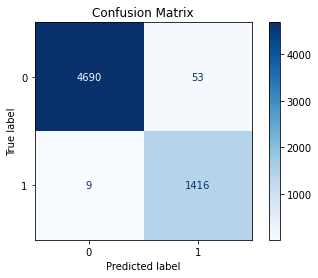

In [ ]:
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_decisionTree_new))
print('\nPrecision: %.6f' % precision_score(Y_test_new, Y_pred_decisionTree_new))
print('\nRecall: %.6f' % recall_score(Y_test_new, Y_pred_decisionTree_new))
print('\nF1: %.6f' % f1_score(Y_test_new, Y_pred_decisionTree_new))

disp = plot_confusion_matrix(model_dct_new, X_test_new, Y_test_new,
        display_labels=['0', '1'], cmap=plt.cm.Blues, values_format = '.0f')
disp.ax_.set_title('Confusion Matrix')

## **Grid Search**

In [ ]:
# Grid Search
pipe = Pipeline([('classifier' , DecisionTreeClassifier())])
param_grid = [
    {'classifier' : [DecisionTreeClassifier()],
     'classifier__ccp_alpha': np.linspace(0.0, 0.1, 10, endpoint=True),
     'classifier__max_depth': [2,3,4,5,12,16,20],
     'classifier__min_samples_split' : [2, 3, 4],
    'classifier__min_samples_leaf' : [1, 2, 5, 10],
    'classifier__max_features' : ['None','auto', 'sqrt', 'log2']}
]

clf_new = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True,
            n_jobs=-1, scoring = 'accuracy')

In [ ]:
best_clf_decisionTree_new = clf_new.fit(X_train_new, Y_train_new.ravel())

Fitting 5 folds for each of 3360 candidates, totalling 16800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2760 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 6760 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 12360 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 16800 out of 16800 | elapsed:  1.8min finished


In [ ]:
# Xuất model
filename = "DecisionTreeClassifier_grid.pkl"
filehandler = open(filename, "wb")

pickle.dump(best_clf_decisionTree_new, filehandler)

In [ ]:
best_clf_decisionTree_new.best_params_

{'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=20, max_features='log2', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'classifier__ccp_alpha': 0.0,
 'classifier__max_depth': 20,
 'classifier__max_features': 'log2',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2}

In [ ]:
Y_pred_decisionTree_new = best_clf_decisionTree_new.predict(X_test_new)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test_new, Y_pred_decisionTree_new, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_decisionTree_new))

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      4743
     class 1       0.98      0.98      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168


Accuracy: 0.990921


In [ ]:
target_names = ['class 0', 'class 1']
report=classification_report(Y_test_new, Y_pred_decisionTree_new, target_names=target_names,output_dict=True)
dt = pd.DataFrame(report).transpose()
dt.to_csv("DecisionTreeClassifier_grid_info"+".csv")


Accuracy: 0.990921

Precision: 0.982382

Recall: 0.978246

F1: 0.980309


Text(0.5, 1.0, 'Confusion Matrix')

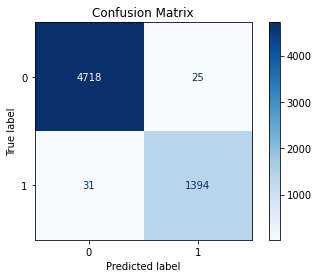

In [ ]:
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_decisionTree_new))
print('\nPrecision: %.6f' % precision_score(Y_test_new, Y_pred_decisionTree_new))
print('\nRecall: %.6f' % recall_score(Y_test_new, Y_pred_decisionTree_new))
print('\nF1: %.6f' % f1_score(Y_test_new, Y_pred_decisionTree_new))

disp = plot_confusion_matrix(best_clf_decisionTree_new, X_test_new, Y_test_new,
        display_labels=['0', '1'], cmap=plt.cm.Blues, values_format = '.0f')
disp.ax_.set_title('Confusion Matrix')

# **Gaussian Naive Bayes...**

In [ ]:
model_gnb_new = GaussianNB().fit(X_train_new, Y_train_new.ravel())

In [ ]:
model_gnb_new

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
# Xuất model
filename = type(model_gnb_new).__name__ + ".pkl"
filehandler = open(filename, "wb")

pickle.dump(model_gnb_new, filehandler)

In [ ]:
Y_pred_GaussianNB_new = model_gnb_new.predict(X_test_new)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test_new, Y_pred_GaussianNB_new, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_GaussianNB_new))

              precision    recall  f1-score   support

     class 0       0.99      0.95      0.97      4743
     class 1       0.85      0.98      0.91      1425

    accuracy                           0.96      6168
   macro avg       0.92      0.96      0.94      6168
weighted avg       0.96      0.96      0.96      6168


Accuracy: 0.956388


In [ ]:
target_names = ['class 0', 'class 1']
report=classification_report(Y_test_new, Y_pred_GaussianNB_new, target_names=target_names,output_dict=True)
dt = pd.DataFrame(report).transpose()
dt.to_csv("GaussianNB_info"+".csv")


Accuracy: 0.956388

Precision: 0.854167

Recall: 0.978246

F1: 0.912005


Text(0.5, 1.0, 'Confusion Matrix')

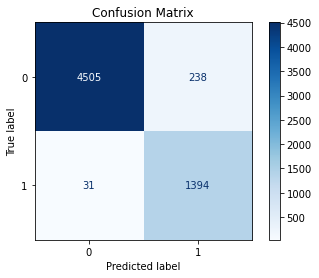

In [ ]:
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_GaussianNB_new))
print('\nPrecision: %.6f' % precision_score(Y_test_new, Y_pred_GaussianNB_new))
print('\nRecall: %.6f' % recall_score(Y_test_new, Y_pred_GaussianNB_new))
print('\nF1: %.6f' % f1_score(Y_test_new, Y_pred_GaussianNB_new))

disp = plot_confusion_matrix(model_gnb_new, X_test_new, Y_test_new,
        display_labels=['0', '1'], cmap=plt.cm.Blues, values_format = '.0f')
disp.ax_.set_title('Confusion Matrix')

## **Grid Search**

In [ ]:
# Grid Search
pipe = Pipeline([('classifier' , GaussianNB())])
param_grid = [
    {'classifier' : [GaussianNB()],
     'classifier__var_smoothing' : np.logspace(0,-9, num=100)}
]

clf_NB = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True,
            n_jobs=-1, scoring = 'accuracy')

In [ ]:
best_clf_NB = clf_NB.fit(X_train_new, Y_train_new.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.5s finished


In [ ]:
best_clf_NB.best_params_

{'classifier': GaussianNB(priors=None, var_smoothing=0.1873817422860384),
 'classifier__var_smoothing': 0.1873817422860384}

In [ ]:
Y_pred_GaussianNB_new = best_clf_NB.predict(X_test_new)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test_new, Y_pred_GaussianNB_new, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_GaussianNB_new))

              precision    recall  f1-score   support

     class 0       1.00      0.98      0.99      4743
     class 1       0.95      1.00      0.97      1425

    accuracy                           0.99      6168
   macro avg       0.97      0.99      0.98      6168
weighted avg       0.99      0.99      0.99      6168


Accuracy: 0.987516



Accuracy: 0.987516

Precision: 0.949333

Recall: 0.999298

F1: 0.973675


Text(0.5, 1.0, 'Confusion Matrix')

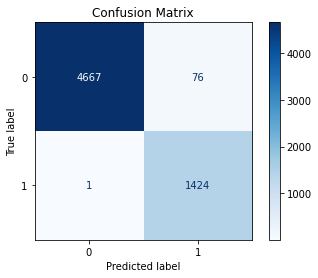

In [ ]:
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_GaussianNB_new))
print('\nPrecision: %.6f' % precision_score(Y_test_new, Y_pred_GaussianNB_new))
print('\nRecall: %.6f' % recall_score(Y_test_new, Y_pred_GaussianNB_new))
print('\nF1: %.6f' % f1_score(Y_test_new, Y_pred_GaussianNB_new))

disp = plot_confusion_matrix(best_clf_NB, X_test_new, Y_test_new,
        display_labels=['0', '1'], cmap=plt.cm.Blues, values_format = '.0f')
disp.ax_.set_title('Confusion Matrix')

# **Logistic Regression...**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
model_scale = scaler.fit(X_train_new)
X_train_n = scaler.transform(X_train_new)
X_test_n = scaler.transform(X_test_new)

In [ ]:
X_train_n

array([[0.30508475, 0.80074857, 0.02972802, ..., 0.        , 0.        ,
        1.        ],
       [0.24776579, 0.66490533, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.46224961, 0.39630119, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.2385208 , 0.60347864, 0.27387729, ..., 1.        , 0.        ,
        0.        ],
       [0.83821263, 0.25128431, 0.45762176, ..., 1.        , 0.        ,
        0.        ],
       [0.38828968, 0.85733157, 0.27387729, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
# Default model
logisticRegr_new = LogisticRegression(solver='liblinear')
logisticRegr_new.fit(X_train_n, Y_train_new.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Xuất model
filename = type(logisticRegr_new).__name__ + ".pkl"
filehandler = open(filename, "wb")

pickle.dump(logisticRegr_new, filehandler)

In [ ]:
Y_pred_logisticRegr_new = logisticRegr_new.predict(X_test_n)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test_new, Y_pred_logisticRegr_new, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_logisticRegr_new))

              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99      4743
     class 1       0.96      0.98      0.97      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.98      6168
weighted avg       0.99      0.99      0.99      6168


Accuracy: 0.987840


In [ ]:
target_names = ['class 0', 'class 1']
report=classification_report(Y_test_new, Y_pred_logisticRegr_new, target_names=target_names,output_dict=True)
dt = pd.DataFrame(report).transpose()
dt.to_csv("LogisticRegression_info"+".csv")


Accuracy: 0.987840

Precision: 0.964237

Recall: 0.983860

F1: 0.973949


Text(0.5, 1.0, 'Confusion Matrix')

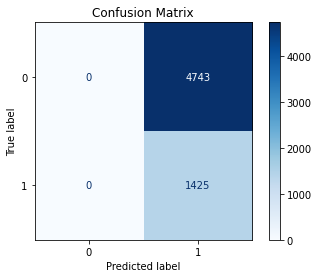

In [ ]:
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_logisticRegr_new))
print('\nPrecision: %.6f' % precision_score(Y_test_new, Y_pred_logisticRegr_new))
print('\nRecall: %.6f' % recall_score(Y_test_new, Y_pred_logisticRegr_new))
print('\nF1: %.6f' % f1_score(Y_test_new, Y_pred_logisticRegr_new))

disp = plot_confusion_matrix(logisticRegr_new, X_test_new, Y_test_new,
        display_labels=['0', '1'], cmap=plt.cm.Blues, values_format = '.0f')
disp.ax_.set_title('Confusion Matrix')

## **Grid Search**

In [ ]:
# Grid Search
pipe = Pipeline([('classifier' , LogisticRegression())])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__class_weight' : ['None', 'balanced'],
     'classifier__max_iter': [200],
     'classifier__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag']}
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True,
            n_jobs=-1, scoring = 'accuracy')

In [ ]:
best_clf_new = clf.fit(X_train_n, Y_train_new.ravel())

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.8min finished


In [ ]:
filename = "LogisticRegression_grid.pkl"
filehandler = open(filename, "wb")

pickle.dump(best_clf_new, filehandler)

In [ ]:
filename = type(best_clf_new).__name__ + ".pkl"
filehandler = open(filename, "wb")

pickle.dump(best_clf_new, filehandler)

In [ ]:
best_clf_new.best_params_

{'classifier': LogisticRegression(C=206.913808111479, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=200, multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__C': 206.913808111479,
 'classifier__class_weight': 'balanced',
 'classifier__max_iter': 200,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [ ]:
Y_pred_logisticRegr_new = best_clf_new.predict(X_test_n)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test_new, Y_pred_logisticRegr_new, target_names=target_names))
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_logisticRegr_new))

              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99      4743
     class 1       0.97      1.00      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168


Accuracy: 0.991569


In [ ]:
target_names = ['class 0', 'class 1']
report=classification_report(Y_test_new, Y_pred_logisticRegr_new, target_names=target_names,output_dict=True)
dt = pd.DataFrame(report).transpose()
dt.to_csv("LogisticRegression_grid_info"+".csv")


Accuracy: 0.991569

Precision: 0.966056

Recall: 0.998596

F1: 0.982057


Text(0.5, 1.0, 'Confusion Matrix')

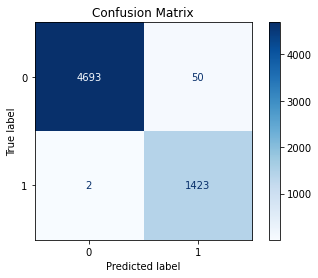

In [ ]:
print('\nAccuracy: %.6f' % accuracy_score(Y_test_new, Y_pred_logisticRegr_new))
print('\nPrecision: %.6f' % precision_score(Y_test_new, Y_pred_logisticRegr_new))
print('\nRecall: %.6f' % recall_score(Y_test_new, Y_pred_logisticRegr_new))
print('\nF1: %.6f' % f1_score(Y_test_new, Y_pred_logisticRegr_new))

disp = plot_confusion_matrix(best_clf_new, X_test_n, Y_test_new,
        display_labels=['0', '1'], cmap=plt.cm.Blues, values_format = '.0f')
disp.ax_.set_title('Confusion Matrix')

# **Graph**

In [ ]:
None_grid = {'Decision Tree' : 0.989462, 'Gaussian Naive Bayes' : 0.974870, 'Logistic Regression' : 0.990110}

With_grid = {'DT + Grid' : 0.991083, 'GNB' : 0.974870, 'LR + Grid' : 0.990597}


fig = plt.figure(figsize = (16, 10))

<Figure size 1152x720 with 0 Axes>

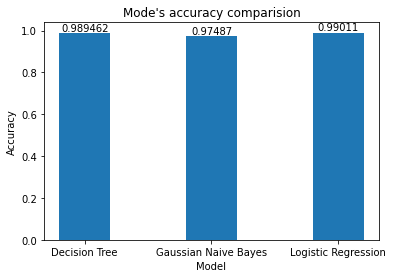

In [ ]:
labels = list(None_grid.keys()) 
values = list(None_grid.values())

y = [val for val in None_grid.values()]

plt.bar(labels, values, width = 0.4)

xlocs, xlabs = plt.xticks()

for i, v in enumerate(y):
    plt.text(xlocs[i], v + 0.01, str(v), horizontalalignment="center")

plt.xlabel("Model") 
plt.ylabel("Accuracy")
plt.title("Mode's accuracy comparision") 
plt.show()

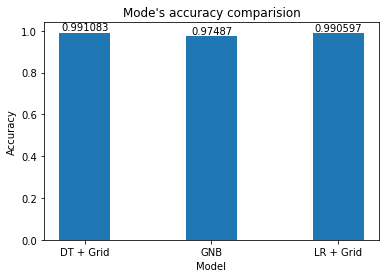

In [ ]:
labels = list(With_grid.keys()) 
values = list(With_grid.values())

y = [val for val in With_grid.values()]

plt.bar(labels, values, width = 0.4)

xlocs, xlabs = plt.xticks()

for i, v in enumerate(y):
    plt.text(xlocs[i], v + 0.01, str(v), horizontalalignment="center")

plt.xlabel("Model") 
plt.ylabel("Accuracy")
plt.title("Mode's accuracy comparision") 
plt.show()

In [ ]:
br1 = np.arange(len(bars1)) 
br2 = [x + barWidth for x in br1] 
   
# Make the plot 
plt.bar(br1, IT, color ='r', width = barWidth, 
        edgecolor ='grey', label ='IT') 
plt.bar(br2, ECE, color ='g', width = barWidth,
        edgecolor ='grey', label ='ECE') 
   
# Adding Xticks
plt.xlabel('Model', fontweight ='bold') 
plt.ylabel('Accuracy', fontweight ='bold') 
plt.xticks([r + barWidth for r in range(len(IT))], 
           ['2015', 'Gaussian Naive Bayes', 'Logistic Regression']) 

# Dump file

In [ ]:
df = pd.read_csv("data/ocupancy_data_processed_train.csv", index_col=0)
feature_cols = df.columns.tolist()
feature_cols.remove('Occupancy')
lable_cols = ["Occupancy"]
feature = df[feature_cols].to_numpy()
label = df[lable_cols].to_numpy()
# normalize
# train
ccppath=DecisionTreeClassifier().fit(feature,label)
# model =  DecisionTreeClassifier(ccp_alpha=0.001).fit(feature, label)
print(ccppath)
# save model
filename = "../model/Decisiontree.pkl"
filehandler = open(filename, "wb")

pickle.dump(model, filehandler)

In [ ]:
model=pickle.load(open('model/Decisiontree.pkl', 'rb'))
print(model)
Y_pred_decisionTree = model.predict(feature)
report=classification_report(label, Y_pred_decisionTree, target_names=target_names,output_dict=True)
dt = pd.DataFrame(report).transpose()
dt.to_csv("model/Decisiontree_info.csv")
print(dt)
print('\nAccuracy: %.2f' % accuracy_score(label, Y_pred_decisionTree))